In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

%run insights.py
%run plot.py

In [3]:
spark = SparkSession.builder.getOrCreate()

In [16]:
# Load all datasets
metrics = spark.read.load('../data/dataset_metrics.parquet').toPandas()
score_metrics = spark.read.load('../data/score_metrics.parquet').toPandas().set_index('score')
comments = spark.read.load('../data/sample.parquet')
comments.registerTempTable("comments")
daily_metrics = spark.read.load('../data/daily_metrics.parquet').toPandas().set_index('created')
subreddit_agreement = spark.read.load('../data/subreddit_agreement.parquet').toPandas().set_index('subreddit')
daily_agreement = spark.read.load('../data/daily_agreement.parquet').toPandas().set_index('created')
lda_result_one_w_df = spark.read.load('../data/oneW_oneT_lda_result.parquet').toPandas().set_index('post_id')
lda_result_three_w_df = spark.read.load('../data/threeW_twoT_lda_result.parquet').toPandas().set_index('post_id')
nlp = spark.read.load('../data/subreddit_nlp_full_0.001.parquet')

### Dataset Description

##### Source

Our dataset contains all the comments available on Reddit from December 2005 to March 2017. It was firstly parsed and publicly maide avaible by a reddit user by the name of u/Stuck_in_the_Matrix [on 2015](https://www.reddit.com/r/datasets/comments/3bxlg7/i_have_every_publicly_available_reddit_comment/). Two years later, the user u/Dewarim provided torrents for [an updated version of the dataset](https://www.reddit.com/r/datasets/comments/65o7py/updated_reddit_comment_dataset_as_torrents/) which also includes all the comments from 2015 up to March 2017. This updated version is the one used as our dataset.


##### Overview & Schema

Before diving into the information we extracted from the dataset, let's look at the types of values that are contained within it. 

In [4]:
comments.printSchema()

root
 |-- distinguished: string (nullable = true)
 |-- retrieved_on: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- flair_text: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- ups: integer (nullable = true)
 |-- downs: integer (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_context: string (nullable = true)
 |-- flair_css_class: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- score_hidden: boolean (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- controversiality: integer (nullable = true)
 |-- body: string (nullable = true)
 |-- archived: boolea

In the context of our data collection, we specifically looked at the following types,

* `created_utc` to be able to date the comment
* `author`, `subreddit_id` and `link_id` to aggregate the comments per author, topic or post.
* `ups`, `downs` and `score` to represent the high-level sentiment of the community with regards to the comment.
* `controversiality`, which is a pre-computed metric of controversiality.
* `body` in order to extract topics and sentiment from the text itself.

We will dive successively into each of these topics in this notebook. But first, let's start with the basic information about the dataset, i.e. its size and range of dates.

In [5]:
insights_comments(metrics)

> The dataset contains a total of **3,092,028,928** comments ranging from **12/12/2005** to **03/31/2017**.

An important thing to note given the schema seen above is that we do not have access to the content of the posts, only the comments. We do however have access to the id of the post (`link_id`) on which the comments are written. We can use this information, for instance to group comments that related to the same post. It is also possible to calculate the total number of posts (with at least one reply) on Reddit.

In [6]:
insights_posts(metrics)

> There is a total of **204,469,276** posts on Reddit with at least one reply.

Moreover, it is also important to understand the notion of *thread* in Reddit comments. Each comment has a parent, defined by `parent_id`. It means that comments might be at different depth. Top-level comments (which have depth 0 and answer the original post directly) will have the post id as `parent_id`. Lower-level comments on the other hand, have another comment as parent. We can use this information to extract the number of top-level comments and lower-level comments from the dataset.

In [7]:
insights_comments_levels(metrics)

> Out of all the comments, **1,223,260,504** (**39.56%** of the dataset) are top-level comments. This makes an average of **5.98** top-level comments per post. The other **1,868,768,424** (**60.44%**) are replies to other comments.

##### Deleted and Removed Comments

Some comments are marked as `[deleted]` or `[removed]`. According to [this Reddit post](https://www.reddit.com/r/help/comments/38cjx8/user_delete_vs_mod_delete_how_to_tell_the/), the `[deleted]` means that the comment was simply deleted by its author. There are a few reasons to do that, for instance to hide a negative comment from one's history, or to avoid getting more downvotes that we already have and prevent one's karma from getting too low. 

In [8]:
insights_removed(metrics)

> A total of **186,592,666** comments were deleted by their authors, which is **6.03%** of the dataset.

On the other hand, `[removed]` indicates comments that were removed from the moderation team of the subreddit that the comment belongs to. This can also indicate potential toxic or vulgar comments, but it is not very reliable as it can also include off-topic comments.

In [9]:
insights_deleted(metrics)

> A total of **25,544,034** comments were removed by the moderation teams, which is **0.83%** of the dataset.

##### Score

On Reddit, people can *upvote* (`ups` in the dataset) posts or comments that they agree with, and *downvote* (`downs`) comments with which they do not agree. These values are then used to calculate a `score` metric with a simple formula `ups - downs`. 

Unfortunately for us, even though the dataset sometimes include `ups` and `downs` attributes, their value seems to be completely wrong. In fact, there is no instance where `downs` is different than 0.

In [10]:
spark.sql("""SELECT downs, COUNT(*) FROM comments GROUP BY downs""").show()

+-----+--------+
|downs|count(1)|
+-----+--------+
| null| 2637603|
|    0| 3543945|
+-----+--------+



This is very problematic for us, as we were hoping to come up with our own formula for measuring polarity based on the number of upvotes and downvotes of a comment. For now, we will have to restrict ourselves to only using `score`. Let's see what the range of `score` is.

In [11]:
insights_score(score_metrics)

> The highest score of all the dataset is **88,484** and the lowest score is **-12,063**.

Now, let's look at the distribution of `score`. Since it can be negative, we will have to plot the positive and negative scores separately. (and it is required for log-log plots).

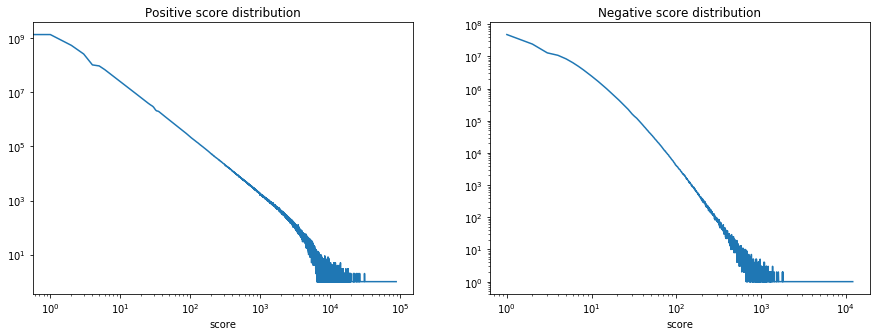

In [12]:
plot_scores(score_metrics)

We can see that the positive score seems to follow a nice power law. We will need to improve / confirm that later on with a cumulative and smoothed out plots, but this will require additional computations which we do not have time to run as of yet. Interestingly enough, the negative score is not as straight and indicates that the negative scores do not follow the same power law as the positive scores do. 

### Evolution over Time

Now, our goal was to understand how the Reddit community has evolved in terms of controversiality, polarity and aggressivity over time. Our first step towards understanding such evolution was to visualize how the above metrics (as well as additional ones) have changed over the years.

##### General Reddit Traffic

Let's first see how the overall traffic has evolved over Reddit. Because the daily data can be very noisy (in blue below), we perform a 60-day window average for all of the following metrics (in orange). 

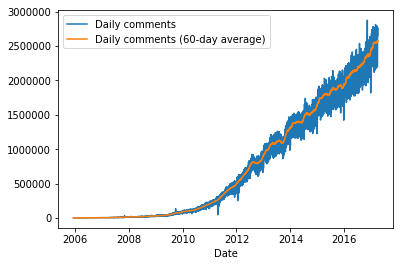

In [13]:
plot_daily_metric(daily_metrics, "count_of_comments")

We can see here that the number of comments on Reddit, after a slow start between 2005 and 2009, has ever since been steadily increasing. Moreover, the curve is similar to the **daily active users** which we can see below.

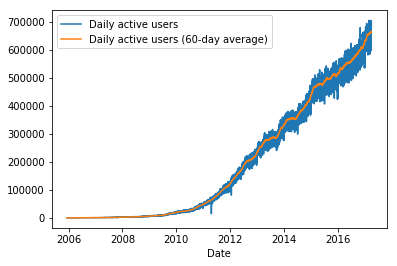

In [14]:
plot_daily_metric(daily_metrics, "count_of_users")

### Polarity & Controversiality Metrics

Now, we would like to narrow our focus down to the idea of measuring divisiveness on Reddit. Even before diving into the text of the comments, there are some high-level metrics that we can try to compute based on some of the attributes, for instance the `score`. Here is a list of such metrics and how they changed in time.

##### Controversiality

As we can see in the dataset schema, Reddit does provide a binary flag `controversiality` for each of the comments. If we trust [Koooooj
's explanation](https://www.reddit.com/r/NoStupidQuestions/comments/3xmlh8/what_does_something_being_labeled_controversial/cy5yk1m), as well as Reddit's [announcement of the feature](https://www.reddit.com/r/announcements/comments/293oqs/new_reddit_features_controversial_indicator_for/) a comment is flagged controversial when both down and up votes are high but their difference gets under a certain undisclosed threshold. In other words, Reddit will consider something to be controversial whenever it receives a high similar amount of down and up votes, which means that the community was evenly polarized by the comment's content.

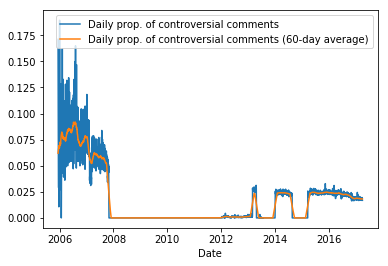

In [15]:
plot_daily_metric(daily_metrics, "prop_of_controversial")

Unfortunately, as we can see here, the `controversiality` metric is set to `0` to all the posts between 2008 and 2012, and there are two more gaps after that. Based on this, it will not be a very valuable metric over the long term. We might still be able to use it from 2015 onward, as it seems to be working properly there.

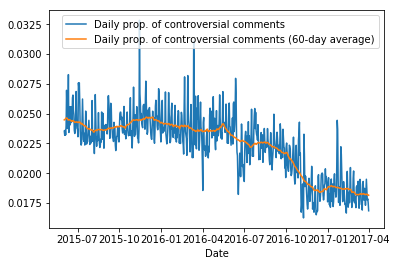

In [16]:
plot_daily_metric(daily_metrics[daily_metrics.index > dt.date(2015, 6, 1)], "prop_of_controversial")

##### Deletion and Moderation

Another indirect metric that could be interesting to look at is the number of comments that were removed from the moderation. Such comments are identifiable by the fact that their body has changed to `[removed]`. This also means that we do not have access to the previous content of such messages. We do not believe that this metric is meaningful enough on its own, but it could be interesting to use it as a supplement to another analysis. Again, there are many factors that could contribute to a post being removed, for instance if it breaks the rules of a subreddit.

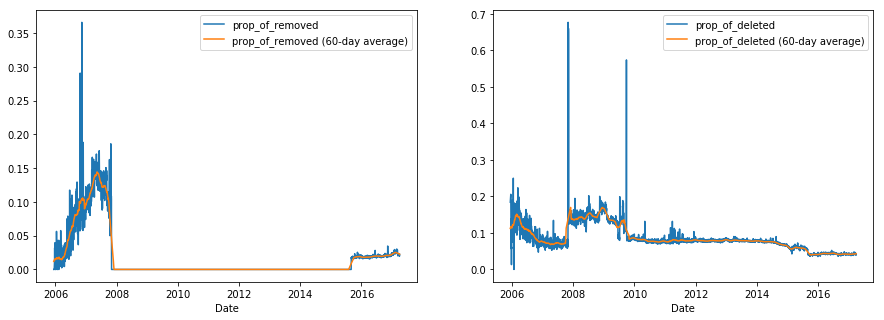

In [17]:
plot_daily_metrics(daily_metrics, "prop_of_removed", "prop_of_deleted")

These plots seem to indicate that there is some inconsistencies in how to dataset handles `[removed]` and `[deleted]`, which contradicts our original assumption. Moreover, the date after which `[removed]` is consistently 0 seem to coincide with the big spike seen in the number of `[deleted]`. One possible explanation would be that after this date, all `[removed]` were actually changed to `[deleted]`.

##### Agreement Factor

Now for a first metric that we computed by hand, the agreement factor is actually something fairly easy to compute. It basically takes the ratio of comments with positive score over the total number of comments. The intuition is that in controversial topics and/or echo-chamber situations, more posts are expected to be downvoted by the dominant community. 

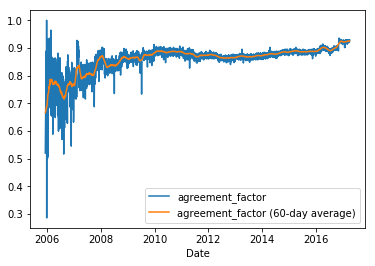

In [18]:
plot_daily_metric(daily_agreement, 'agreement_factor')

This result contradicts what we were expecting, as we can see that the *agreement factor* has actually been increasing relatively steadily. This could however hint at the fact that Reddit has become more of an echo chamber over time. Of course, this might not be the only factor, and there might be several biases related to this metric. For instance, a post with negative score does not necessarily indicate a divergence of opinion, it could simply be a post that does not respect the rules of a community, someone providing wrong information or a comment that does not add anything to the dicussion like "lol" or "ok".

We can also see on this graph that there is a spike around the beginning of 2017, let's zoom in to see exactly where.

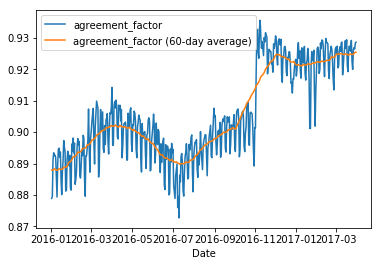

In [19]:
plot_daily_metric(daily_agreement[daily_agreement.index > dt.date(2016, 1, 1)], 'agreement_factor')

This spike in agreement seems to be located at the beginning of November. This exactly matches the moment at which the results of Trump's election came out. Is this a coincidence, or is there some underlying bias that we failed to take into account? We would have to do a more in-depth analysis to find out.

Finally, an interesting possible way to see if our "agreement factor" metric makes sense would be to visualize it per subreddit and see what the subreddits with lowest agreement factors are. Here are the first 20:

In [20]:
subreddit_agreement[subreddit_agreement['count'] > 3000][['count', 'agreement_factor']].sort_values('agreement_factor').head(20)

,count,agreement_factor
subreddit,,
blog,7350,0.724762
RocketLeagueExchange,18228,0.738644
GlobalOffensiveTrade,5607,0.764045
entertainment,4467,0.783747
xboxone,62751,0.798967
worldnews,577781,0.801754
worldpolitics,8246,0.802328
blackdesertonline,12471,0.804747
Austin,28946,0.808298


Interestingly, the lowest subreddit is **[r/blog](https://www.reddit.com/r/blog)**. One way to interpret this result is that this subreddit is managed by the Reddit company itself and is one of the few places where the community can express their opinion on the decisions and changes made by the Reddit developpers. In 2017, Reddit has announced and/or made some controversial updates to their app (e.g. redesigning the front page, modifying their ranking algorithm, etc..) and these polarizing topics could be represented by the result we get here.

Now for the remaining ones, it is interesting to see that they almost all fall into a few categories:

* **Video Games** - `r/RocketLeagueExchange`, `r/GlobalOffensiveTrade`, `r/xboxone`, `r/blackdesertonline`, `r/ConanExiles`, `r/kotk`, `r/bladeandsoul`, `r/PUBATTLEGROUNDS` are all subreddits dedicated to specific games or consoles. Given the fact that online games tend to always be somewhat toxic (taken from our own experience), this was indeed to be expected.
* **Politics & News** - As we could also expect, subreddits linked to politics and news have a low agreement factor. `r/worldnews`, `r/news` and `r/worldpolitics` all rank very low here. Later on, it will be interesting to analyze how these specific subreddits have evolved over time.
* **Cities** - Interestingly enough, it seems that conversation might get controversial when talking about cities. This can actually makes sense, as these types of discussions are often fairly emotional and involve people with wildly different experiences and opinions. According to this metric, `r/Austin`, `r/Minneapolis` and `r/nyc` are the top 3 cities about which are less in agreement.

We also note the present of `r/subredditcancer`, which seems to be the home of users who got banned from other subreddits because of their sometimes extreme opinions, as well as `r/TwoXChromosomes`, a subreddit dedicated to conversations about and between women and `r/RealGirls` \[**NSFW**\] an amateur pornographic subreddit about women.

### Trend Modelling

In order to detect trends in such a big dataset we need some way to extract the discussion's subject from reddit threads. One common and efficient way to perform this on textual data, is to use the Latent Dirichlet Allocation (LDA) algorithm which given a text input and some hyper parameters, can extract a variable number of topics from the text. 

#### Trend analysis of the month preceding the election, using 1 topic by post, and 1 word per topic

To test the efficiency of LDA on reddit discussions, we ran the algorithm on all comments from the subreddit "news" during the month preceding the 2016 US presidential election, to see if indeed the upcoming election was discussed. This could prove to be useful in the light of the preceding findings, as _r/news_ is part of the subreddit with the lowest agreement factor. Thus it could be useful to understand on which subject the reddit users are not agreeing and polarized.

The most simple and general topic modelling that can be done, is asking the LDA to produce only one topic consisting of 1 word per post. Let's see what was the 20 most discussed topic during this month, according to the frequency of each topic per post:

In [21]:
frequency_df = lda_result_one_w_df['topic'].value_counts()
frequency_df.head(20)

people      394
would       135
police       77
article      50
school       41
child        39
trump        38
woman        35
pipeline     33
clown        33
could        29
state        28
attack       26
actually     25
black        25
right        24
phone        24
american     23
russia       22
officer      22
Name: topic, dtype: int64

With only one topic limited to one word, we obviously generalize a bit too much the discussions and we get very broad subjects such as "people" as the most frequent topic. Of course, most of the discussions about news might be centered around people, so it does not really come as a surprise. Most of the other frequents topics are terms which easily get some miscellaneous headlines in news outlet such as "police", "school", "state", "phone" or "crime". 

However the word "trump" still appear to be the fifth most frequent topic during this timeframe, which comes as no surprise, as this data sample is centered on the month before the election day. Nonetheless, the relative frequency of this topic is a good news for our research. It shows that "trump" was indeed an important topic of discussion in reddit news the month before the election meaning the LDA may help us identify some trends in discussions.

The rival of Donald Trump for the 2016 election, Hillary Clinton, is surprinsingly absent from this ranking. This could either means she was less discussed than Donald Trump, or that more often the LDA would categorize another word as being the topic of the thread (such as "woman" potentially). 

Let's plot comparatively the number of post whose subject was one of the two presidential candidates during this month :

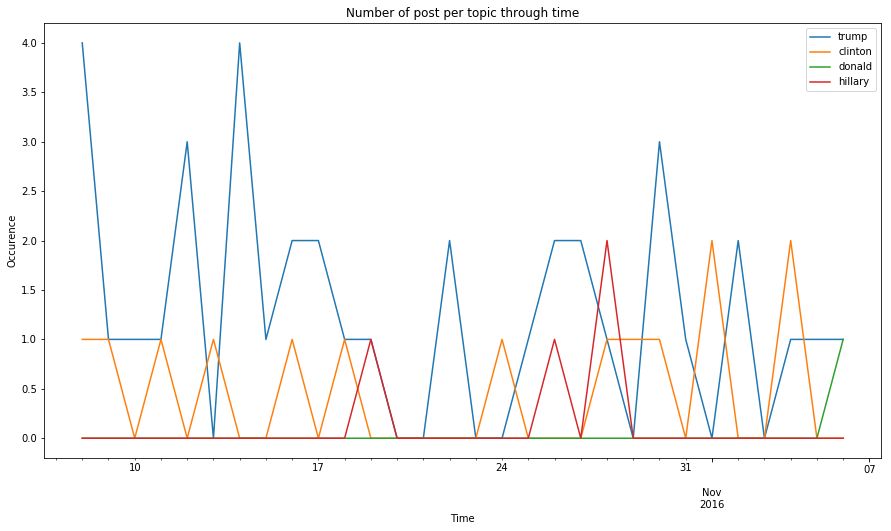

In [22]:
topics = ['trump', 'clinton', 'donald', 'hillary']
plot_frequency_of_topics(lda_result_one_w_df, topics)

The plot above shows us an interesting phenomena, although the word "clinton" and "hillary" were absent from the 20 most discussed topic we showed previously, both words seems to share a similar distribution in magnitude through time, whereas for Donald Trump, most of the time he's subjectified by its family name rather by its first name (which get recognized as a topic only once, on the 6th of November). Even though "clinton" might be referring to another person bearing this family name, the context of the election assures us this word probably refers to the same person as the word "hillary".

This might explain why Hillary Clinton was not as subjectified as Donald Trump according to the LDA results, the people would refer to her under two different words during discussion, while they would be more consistent with the current U.S. president by calling him "Trump".

Merging all the possible word as name for the presidential candidate gives us this distribution through time instead:

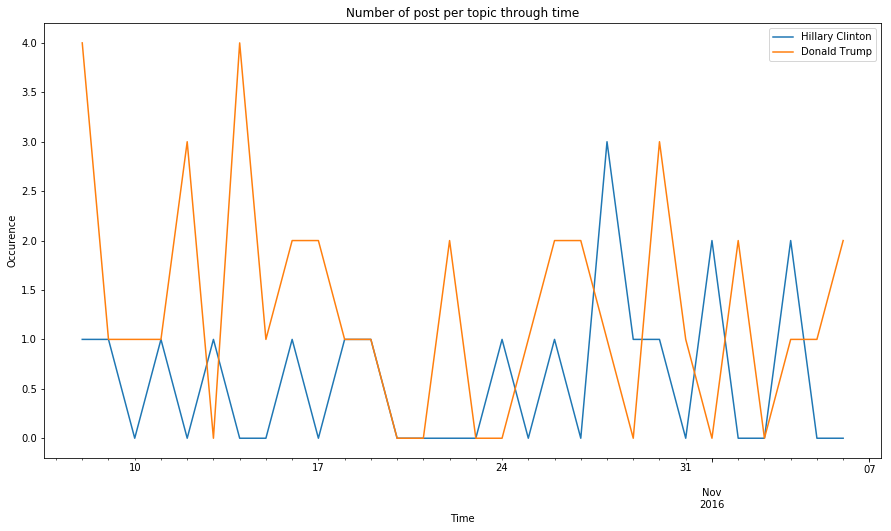

In [23]:
hc = 'Hillary Clinton'
dt = 'Donald Trump'
lda_result_one_w_df['topic'] = lda_result_one_w_df['topic'].map({'hillary': hc, 'clinton': hc, 'donald':dt, 'trump':dt})
plot_frequency_of_topics(lda_result_one_w_df, [hc, dt])

The corrected occurence through time distribution shows us that although Trump was the dominant subject at the beginning of the month of October, both subjects started to have an equal representation as the election day was coming.

This proves some trend analysis can be done using LDA, but we should take it with a grain of salt, as the number of occurence stays relatively low (under 5 posts whose topic was identified to be about a presidential candidate per day), probably because LDA will favor more general terms such as "people" or "would" as topic of discussion.

#### Trend Analysis using 2 topics by post, and 3 words per topic

The LDA algorithm allows some more fine grained topic modelling by changing the number of topic produced by thread, and the number of words that can constitute a topic. Testing LDA on the same sample but with increased topic and words per topic might maybe produce less general topics and maybe more representativeness of the actual topic of discussion. 

In [24]:
lda_result_three_w_df['topic'].value_counts().head(30)

people would think         10
people black white          8
right                       6
people think would          4
people black police         4
video                       4
pretty                      4
alive                       4
police people would         4
people would money          4
insurance people health     3
police would officer        3
would people police         3
pipeline would people       3
people white black          3
would people think          3
people would government     3
insurance people would      3
people driving think        3
people right would          3
people police officer       2
shooting police justify     2
surprise                    2
place                       2
hungover                    2
prison people would         2
train track could           2
police people officer       2
update                      2
epstein trump clinton       2
Name: topic, dtype: int64

Obviously, computing three words per topic greatly decreases the odds of having a high count for a given topic, as the most frequent topic being "people would think" occurs only 10 times through all the posts (whereas the topic "people" occured 394 times when considering only one word per topic). Having three words per topic gives a bit more information about the thread's subject, but give less chance of finding a coherent trend.

Regarding the U.S. election, no identical topics seems to adress the subject, but this might be because most topics modelled by the LDA about either Trump or Clinton are not coherent enough to be counted together. We can assume that a three words topic containing the name of either presidential candidate might speak about it, and thus count this way how much Clinton and Trump were discussed.

In [25]:
def replace_str(s):
    if s == 'hillary' or s == 'clinton':
        return hc
    elif s == 'donald' or s == 'trump':
        return dt
    else:
        return s

count_dict = {hc:0, dt:0}
for t in lda_result_three_w_df['topic']:
    ts = t.split(' ')
    ts = [replace_str(tok) for tok in ts]
    for k in count_dict.keys():
        if k in ts:
            count_dict[k] += 1
count_dict

{'Hillary Clinton': 92, 'Donald Trump': 173}

We get a much higher count of occurence in topics for the two presidential candidate than in previous exemple. This means that finding the good number of topics per post and words per topic, might help in correctly modelling the topic of a post, and thus detect trends.

In [11]:
subreddit_agreement[subreddit_agreement['count'] > 10000][['count', 'agreement_factor']].sort_values('agreement_factor').head(20)

,count,agreement_factor
subreddit,,
RocketLeagueExchange,18228,0.738644
xboxone,62751,0.798967
worldnews,577781,0.801754
blackdesertonline,12471,0.804747
Austin,28946,0.808298
news,567665,0.816658
TwoXChromosomes,83078,0.819435
pics,369844,0.821073
nyc,27506,0.827965


In [13]:
subreddit_agreement[subreddit_agreement['count'] > 50000][['count', 'agreement_factor']].sort_values('agreement_factor', ascending=False).head(20)

,count,agreement_factor
subreddit,,
JUSTNOMIL,72471,0.997392
RWBY,68210,0.994356
teenmom,96030,0.989639
exmormon,66736,0.989241
fatlogic,85095,0.986674
The_Donald,1362473,0.984966
PrequelMemes,60820,0.984166
fireemblem,52421,0.983327
stevenuniverse,58174,0.979768


In [18]:
subreddit_agreement.loc['The_Donald']

count               1.362473e+06
count_pos           1.341990e+06
count_neg           2.048300e+04
agreement_factor    9.849663e-01
Name: The_Donald, dtype: float64

In [19]:
subreddit_agreement.loc['LateStageCapitalism']

count               54469.000000
count_pos           50507.000000
count_neg            3962.000000
agreement_factor        0.927261
Name: LateStageCapitalism, dtype: float64

In [24]:
subreddit_agreement.loc['democrats']

count               4193.00000
count_pos           3709.00000
count_neg            484.00000
agreement_factor       0.88457
Name: democrats, dtype: float64

In [25]:
subreddit_agreement.loc['republicans']

count               167.000000
count_pos           151.000000
count_neg            16.000000
agreement_factor      0.904192
Name: republicans, dtype: float64

In [27]:
subreddit_agreement.loc['hearthstonecirclejerk']

count               2196.000000
count_pos           2178.000000
count_neg             18.000000
agreement_factor       0.991803
Name: hearthstonecirclejerk, dtype: float64

In [28]:
subreddit_agreement.loc['circlejerk']

count               6172.000000
count_pos           6052.000000
count_neg            120.000000
agreement_factor       0.980557
Name: circlejerk, dtype: float64

In [29]:
subreddit_agreement.loc['4chan']

count               61112.000000
count_pos           59867.000000
count_neg            1245.000000
agreement_factor        0.979628
Name: 4chan, dtype: float64

In [32]:
subreddit_agreement.loc['FuckYou']

count               571.000000
count_pos           562.000000
count_neg             9.000000
agreement_factor      0.984238
Name: FuckYou, dtype: float64

In [33]:
subreddit_agreement.loc['RoastMe']

count               43850.000000
count_pos           40782.000000
count_neg            3068.000000
agreement_factor        0.930034
Name: RoastMe, dtype: float64

In [34]:
subreddit_agreement.loc['history']

count               28201.000000
count_pos           26267.000000
count_neg            1934.000000
agreement_factor        0.931421
Name: history, dtype: float64

In [35]:
subreddit_agreement.loc['science']

count               46967.000000
count_pos           42553.000000
count_neg            4414.000000
agreement_factor        0.906019
Name: science, dtype: float64

In [36]:
subreddit_agreement.loc['askscience']

count               18329.000000
count_pos           17020.000000
count_neg            1309.000000
agreement_factor        0.928583
Name: askscience, dtype: float64

In [37]:
subreddit_agreement.loc['CatsStandingUp']

count               3962.00000
count_pos           3641.00000
count_neg            321.00000
agreement_factor       0.91898
Name: CatsStandingUp, dtype: float64

In [40]:
subreddit_agreement.loc['aww']

count               147189.000000
count_pos           133061.000000
count_neg            14128.000000
agreement_factor         0.904015
Name: aww, dtype: float64

In [41]:
subreddit_agreement.loc['me_irl']

count               79138.000000
count_pos           76227.000000
count_neg            2911.000000
agreement_factor        0.963216
Name: me_irl, dtype: float64

In [44]:
subreddit_agreement.loc['funny']

count               363875.000000
count_pos           325333.000000
count_neg            38542.000000
agreement_factor         0.894079
Name: funny, dtype: float64

In [42]:
subreddit_agreement.loc['wholesomememes']

count               58112.000000
count_pos           56147.000000
count_neg            1965.000000
agreement_factor        0.966186
Name: wholesomememes, dtype: float64

In [45]:
subreddit_agreement.loc['Fuckthealtright']

count               17994.00000
count_pos           15416.00000
count_neg            2578.00000
agreement_factor        0.85673
Name: Fuckthealtright, dtype: float64

In [46]:
subreddit_agreement.loc['wallstreetbets']

count               45914.000000
count_pos           43191.000000
count_neg            2723.000000
agreement_factor        0.940693
Name: wallstreetbets, dtype: float64

In [47]:
subreddit_agreement.loc['RocketLeague']

count               59427.000000
count_pos           53857.000000
count_neg            5570.000000
agreement_factor        0.906272
Name: RocketLeague, dtype: float64

In [48]:
subreddit_agreement.loc['altright']

count               9924.000000
count_pos           9330.000000
count_neg            594.000000
agreement_factor       0.940145
Name: altright, dtype: float64

In [50]:
subreddit_agreement.loc['neoliberal']

count               2441.000000
count_pos           2310.000000
count_neg            131.000000
agreement_factor       0.946333
Name: neoliberal, dtype: float64

In [51]:
subreddit_agreement.loc['BlueMidterm2018']

count               6375.000000
count_pos           5981.000000
count_neg            394.000000
agreement_factor       0.938196
Name: BlueMidterm2018, dtype: float64

In [57]:
subreddit_agreement.loc['obama']

count               126.00000
count_pos           103.00000
count_neg            23.00000
agreement_factor      0.81746
Name: obama, dtype: float64

In [58]:
subreddit_agreement.loc['ThanksObama']

count               1656.000000
count_pos           1553.000000
count_neg            103.000000
agreement_factor       0.937802
Name: ThanksObama, dtype: float64

In [59]:
subreddit_agreement.loc['socialism']

count               28044.00000
count_pos           25522.00000
count_neg            2522.00000
agreement_factor        0.91007
Name: socialism, dtype: float64

In [60]:
subreddit_agreement.loc['communism']

count               2616.000000
count_pos           2388.000000
count_neg            228.000000
agreement_factor       0.912844
Name: communism, dtype: float64

In [65]:
subreddit_agreement[subreddit_agreement['count'] > 50000].describe()

,count,count_pos,count_neg,agreement_factor
count,1.400000e+02,1.400000e+02,140.000000,140.000000
mean,1.653894e+05,1.508123e+05,14577.128571,0.918552
std,2.636081e+05,2.436343e+05,24887.883468,0.041687
min,5.041000e+04,4.527300e+04,189.000000,0.798967
25%,6.019625e+04,5.608150e+04,4110.500000,0.894980
50%,8.492350e+04,7.791500e+04,6553.500000,0.920940
75%,1.513062e+05,1.338102e+05,14155.250000,0.947793
max,2.155813e+06,2.035769e+06,198631.000000,0.997392


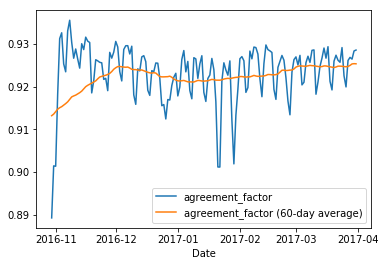

In [88]:
plot_daily_metric(daily_agreement[(daily_agreement.index > dt.date(2016, 10, 29))], 'agreement_factor')

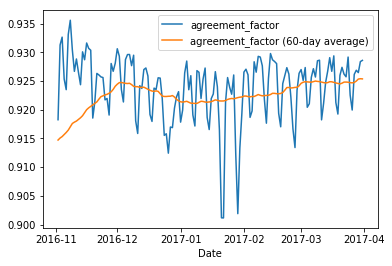

In [85]:
plot_daily_metric(daily_agreement[(daily_agreement.index > dt.date(2016, 11, 1))], 'agreement_factor')

In [89]:
comments

DataFrame[distinguished: string, retrieved_on: string, gilded: int, edited: int, id: string, parent_id: string, flair_text: string, author: string, score: int, ups: int, downs: int, created_utc: string, author_flair_text: string, author_flair_css_class: string, author_flair_context: string, flair_css_class: string, subreddit: string, subreddit_id: string, score_hidden: boolean, stickied: boolean, link_id: string, controversiality: int, body: string, archived: boolean]

In [96]:
spark.sql("""
    SELECT body
    FROM comments
    WHERE subreddit == 'announcements' AND created_utc > 1477785600 AND created_utc < 1478390400
""").show()

+----+
|body|
+----+
+----+



In [97]:
subreddit_agreement.loc['politics']

count               1.574613e+06
count_pos           1.375982e+06
count_neg           1.986310e+05
agreement_factor    8.738541e-01
Name: politics, dtype: float64

In [98]:
subreddit_agreement.loc['askscience']

count               18329.000000
count_pos           17020.000000
count_neg            1309.000000
agreement_factor        0.928583
Name: askscience, dtype: float64

In [99]:
subreddit_agreement.loc['science']

count               46967.000000
count_pos           42553.000000
count_neg            4414.000000
agreement_factor        0.906019
Name: science, dtype: float64

In [101]:
subreddit_agreement.loc['LGBTnews']

count               128.000000
count_pos           119.000000
count_neg             9.000000
agreement_factor      0.929688
Name: LGBTnews, dtype: float64

In [106]:
subreddit_agreement.loc['Libertarian']

count               35964.000000
count_pos           31984.000000
count_neg            3980.000000
agreement_factor        0.889334
Name: Libertarian, dtype: float64

In [107]:
subreddit_agreement.loc['Anarchism']

count               18993.000000
count_pos           17531.000000
count_neg            1462.000000
agreement_factor        0.923024
Name: Anarchism, dtype: float64

In [109]:
subreddit_agreement.loc['socialism']

count               28044.00000
count_pos           25522.00000
count_neg            2522.00000
agreement_factor        0.91007
Name: socialism, dtype: float64

In [111]:
subreddit_agreement.loc['Conservative']

count               50410.000000
count_pos           47560.000000
count_neg            2850.000000
agreement_factor        0.943464
Name: Conservative, dtype: float64

In [115]:
subreddit_agreement.loc['Liberal']

count               1685.000000
count_pos           1434.000000
count_neg            251.000000
agreement_factor       0.851039
Name: Liberal, dtype: float64

In [118]:
subreddit_agreement.loc['Republican']

count               11146.000000
count_pos           10068.000000
count_neg            1078.000000
agreement_factor        0.903284
Name: Republican, dtype: float64

In [130]:
subreddit_agreement.loc['Capitalism']

count               162.000000
count_pos           158.000000
count_neg             4.000000
agreement_factor      0.975309
Name: Capitalism, dtype: float64

In [131]:
subreddit_agreement.loc['Feminism']

count               2664.000000
count_pos           2296.000000
count_neg            368.000000
agreement_factor       0.861862
Name: Feminism, dtype: float64

In [135]:
subreddit_agreement.loc['occupywallstreet']

count               213.000000
count_pos           177.000000
count_neg            36.000000
agreement_factor      0.830986
Name: occupywallstreet, dtype: float64

In [141]:
subreddit_agreement.loc['conspiracy']

count               163363.000000
count_pos           150742.000000
count_neg            12621.000000
agreement_factor         0.922743
Name: conspiracy, dtype: float64

In [144]:
subreddit_agreement.loc['climateskeptics']

count               1510.000000
count_pos           1393.000000
count_neg            117.000000
agreement_factor       0.922517
Name: climateskeptics, dtype: float64

In [150]:
subreddit_agreement.loc['leagueoflegends']

count               323575.000000
count_pos           283852.000000
count_neg            39723.000000
agreement_factor         0.877237
Name: leagueoflegends, dtype: float64

In [156]:
subreddit_agreement.loc['4chan']

count               61112.000000
count_pos           59867.000000
count_neg            1245.000000
agreement_factor        0.979628
Name: 4chan, dtype: float64

In [157]:
subreddit_agreement.loc['guns']

count               58214.000000
count_pos           54361.000000
count_neg            3853.000000
agreement_factor        0.933813
Name: guns, dtype: float64

In [6]:
subreddit_agreement.loc['FULLCOMMUNISM']

count               45248.000000
count_pos           44587.000000
count_neg             661.000000
agreement_factor        0.985392
Name: FULLCOMMUNISM, dtype: float64

In [12]:
subreddit_agreement[subreddit_agreement['agreement_factor'] > 0.95].sort_values('count', ascending=False)

,count,count_pos,count_neg,agreement_factor
subreddit,,,,
The_Donald,1362473,1341990,20483,0.984966
CFB,198176,189352,8824,0.955474
anime,189703,183886,5817,0.969336
CollegeBasketball,187680,178670,9010,0.951993
rupaulsdragrace,164758,157491,7267,0.955893
Showerthoughts,157869,150245,7624,0.951707
CringeAnarchy,122865,118196,4669,0.961999
AskMen,101157,96772,4385,0.956652
AskWomen,97634,94812,2822,0.971096


In [16]:
spark.sql("""
    SELECT STD(score)
    FROM comments
    WHERE subreddit == '4chan'
""").show()

+----------------------------------+
|stddev_samp(CAST(score AS DOUBLE))|
+----------------------------------+
|                 59.38612728132955|
+----------------------------------+



In [17]:
spark.sql("""
    SELECT STD(score) / AVG(score)
    FROM comments
    WHERE subreddit == '4chan'
""").show()

+-----------------------------------------------------------------+
|(stddev_samp(CAST(score AS DOUBLE)) / avg(CAST(score AS BIGINT)))|
+-----------------------------------------------------------------+
|                                                4.614261554826212|
+-----------------------------------------------------------------+



In [18]:
spark.sql("""
    SELECT STD(score) / AVG(score)
    FROM comments
    WHERE subreddit == 'xbox'
""").show()

+-----------------------------------------------------------------+
|(stddev_samp(CAST(score AS DOUBLE)) / avg(CAST(score AS BIGINT)))|
+-----------------------------------------------------------------+
|                                                1.352286899902947|
+-----------------------------------------------------------------+



In [19]:
spark.sql("""
    SELECT STD(score) / AVG(score)
    FROM comments
    WHERE subreddit == 'hearthstonecirclejerk'
""").show()

+-----------------------------------------------------------------+
|(stddev_samp(CAST(score AS DOUBLE)) / avg(CAST(score AS BIGINT)))|
+-----------------------------------------------------------------+
|                                               1.4000217083402695|
+-----------------------------------------------------------------+



In [5]:
a = spark.sql("""
    SELECT 
        subreddit, 
        COUNT(*) as count, 
        AVG(score) as avg_score,
        STD(score) as std_score,
        STD(score) / AVG(score) as avg_std_score,
        SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) AS count_pos,
        SUM(CASE WHEN score < 1 THEN 1 ELSE 0 END) AS count_neg,
        (SUM(CASE WHEN score > 1 THEN 1 ELSE 0 END) / COUNT(*)) AS agreement_factor
    FROM comments
    GROUP BY subreddit
    HAVING COUNT(*) > 100
""")

In [23]:
subreddit_agreement.shape

(6729, 4)

In [6]:
b = a.toPandas()

In [12]:
b[b['count'] > 4000].sort_values('std_score', ascending=False)

,subreddit,count,avg_score,std_score,avg_std_score,count_pos,count_neg,agreement_factor
168,AskReddit,569779,11.004876,120.533037,10.952694,232533,42128,0.408111
2860,BlackPeopleTwitter,5468,20.852597,114.139038,5.473613,3474,725,0.635333
2944,OldSchoolCool,4025,9.453913,109.076042,11.537661,1804,552,0.448199
3255,Jokes,5815,13.584695,104.888820,7.721102,2875,776,0.494411
480,todayilearned,58489,10.116518,97.530625,9.640731,26820,8817,0.458548
1675,gameofthrones,9861,12.201704,97.404739,7.982880,5575,757,0.565358
169,videos,66621,10.923493,94.527921,8.653635,28133,10708,0.422284
1937,IAmA,42888,11.405358,94.365688,8.273803,18043,4585,0.420700
40,nottheonion,6974,10.878979,94.280942,8.666341,3126,972,0.448236
615,news,48265,7.621672,89.915975,11.797408,20422,9189,0.423122


In [15]:
b[b['count'] > 4000].sort_values('agreement_factor', ascending=False)

,subreddit,count,avg_score,std_score,avg_std_score,count_pos,count_neg,agreement_factor
667,counting,5825,2.501974,1.338888,0.535133,4788,23,0.821974
2790,MLPLounge,9037,2.489211,2.023167,0.812774,7085,77,0.783999
3721,TrollXChromosomes,6628,9.493211,37.960346,3.998684,5050,329,0.761919
1940,fatlogic,4762,10.326333,26.617010,2.577586,3586,220,0.753045
3673,childfree,5093,7.226389,17.029559,2.356579,3748,307,0.735912
3107,rupaulsdragrace,5619,9.783057,31.120119,3.181022,4032,444,0.717565
2687,mylittlepony,7221,5.004155,8.821686,1.762872,5173,145,0.716383
1656,BigBrother,5062,6.041881,11.546621,1.911097,3584,353,0.708021
2307,exmormon,6000,4.534500,8.687312,1.915826,4138,102,0.689667
2283,The_Donald,32108,9.085306,39.100056,4.303659,21355,1152,0.665099


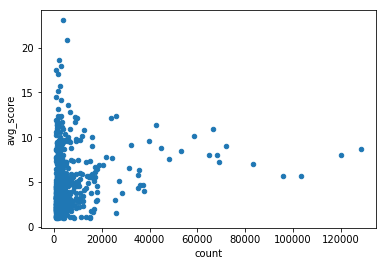

In [61]:
b[(b['count'] > 1000) & (b['count'] <569779)].plot.scatter('count', 'avg_score')

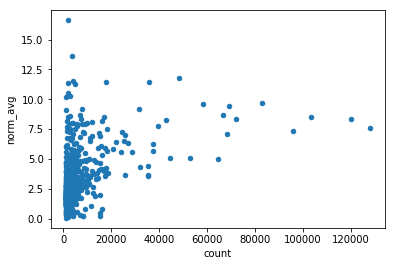

In [62]:
b[(b['count'] > 1000) & (b['count'] <569779)].plot.scatter('count', 'norm_avg')

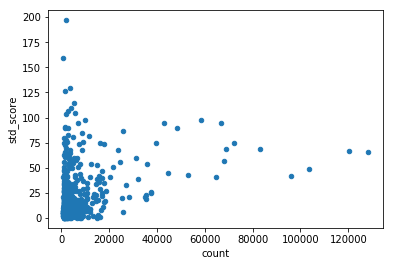

In [65]:
b[(b['count'] > 1000) & (b['count'] < 569779)].plot.scatter('count', 'std_score')

In [66]:
b.corr()

,count,avg_score,std_score,norm_avg
count,1.000000,0.122727,0.279905,0.308462
avg_score,0.122727,1.000000,0.832331,0.543843
std_score,0.279905,0.832331,1.000000,0.811041
norm_avg,0.308462,0.543843,0.811041,1.000000


In [23]:
b[(b['count'] > 1000)].sort_values('avg_std_score', ascending=False)

,subreddit,count,avg_score,std_score,avg_std_score,count_pos,count_neg,agreement_factor
2728,drunk,1731,7.635471,126.879441,16.617108,879,67,0.507799
139,NoMansSkyTheGame,3775,4.248742,57.861720,13.618554,1663,376,0.440530
615,news,48265,7.621672,89.915975,11.797408,20422,9189,0.423122
2944,OldSchoolCool,4025,9.453913,109.076042,11.537661,1804,552,0.448199
290,pcmasterrace,35917,4.661414,53.470208,11.470813,12720,2443,0.354150
2394,explainlikeimfive,17866,6.441117,73.584199,11.424136,7312,2002,0.409269
2005,UpliftingNews,1984,9.118448,103.778686,11.381179,894,321,0.450605
123,space,4806,7.115481,80.153948,11.264727,2023,394,0.420932
168,AskReddit,569779,11.004876,120.533037,10.952694,232533,42128,0.408111
2842,OutOfTheLoop,2022,18.678536,196.837994,10.538192,1192,256,0.589515


In [1]:
b[(b['count'] > 1000) & (b['count'] < 569779)].plot.scatter('count', 'std_score')

NameError: name 'b' is not defined

In [19]:
nlp_df = nlp.toPandas()

Py4JJavaError: An error occurred while calling o90.collectToPython.
: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:280)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.next(SparkPlan.scala:276)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.sql.execution.SparkPlan$$anon$1.foreach(SparkPlan.scala:276)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:298)
	at org.apache.spark.sql.execution.SparkPlan$$anonfun$executeCollect$1.apply(SparkPlan.scala:297)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:186)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:297)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3200)
	at org.apache.spark.sql.Dataset$$anonfun$collectToPython$1.apply(Dataset.scala:3197)
	at org.apache.spark.sql.Dataset$$anonfun$52.apply(Dataset.scala:3259)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:77)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3258)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3197)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
nlp_df.head()

In [27]:
nlp.

2876334

In [236]:
daily_metrics[['count_of_comments_60d_avg', 'count_of_users_60d_avg']].to_csv('../data/daily_traffic.csv')